This is the continuation of the notebook `customer_lead_generator_modelling.ipynb`.

In [20]:
!pip install pycaret[full]

In [21]:
import numpy as np
import pandas as pd

from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os

## 3. Model Development using PyCaret

This is a low-code library facilitating model selection and tuning. Just wanted to give it a try to find a better model, but it did not improve the results much.

### Import the processed data

In [22]:
data_folder = 'data'
filename = 'CustomerData_LeadGenerator.csv'

clean_filename = filename.replace('.csv', '_clean.csv')
customer_data_path_clean = os.path.join(data_folder, clean_filename)

df = pd.read_csv(customer_data_path_clean, index_col=0)
df.head()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,...,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_gekauft_gesamt
0,0,0,0,0,0,0,0,0,0,1,...,195228,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1
1,0,0,0,1,1,1,0,0,0,0,...,168291,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1
2,0,0,0,1,0,1,0,0,0,1,...,189787,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1
3,0,1,1,0,0,0,0,0,0,0,...,189634,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,0
4,0,0,0,0,0,1,0,0,0,1,...,207590,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1


### Train - test split

In [23]:
target = "b_gekauft_gesamt"
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=5, stratify=df[target])
# without stratify=y the class proportions might shift a bit - ensures equal class proportions
df_train.shape, df_test.shape

((3018, 24), (755, 24))

In [24]:
df_test.head()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,...,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_gekauft_gesamt
742,0,1,0,0,1,0,0,0,0,0,...,2193,0.159306,20812.26,32416,1311,0.040443,536.11,318.80,213.21,0
592,0,0,0,0,0,0,0,0,0,0,...,165741,0.176143,23279.07,1962729,295134,0.150369,589.14,320.47,229.28,0
112,0,0,0,0,0,0,0,0,0,1,...,205969,0.189726,23825.90,2285107,334839,0.146531,593.74,327.78,237.38,0
3408,0,0,0,0,0,0,0,0,0,0,...,6289,0.196734,22036.98,76357,4057,0.053132,543.27,333.26,230.41,0
3567,1,0,1,1,1,0,0,0,0,1,...,46642,0.202471,23712.27,503689,70850,0.140662,581.46,323.27,235.25,0


### Import the train and test sets with reduced features using XGBoost

In [25]:
train_data_path = os.path.join(data_folder, 'train_data_selected.csv')
train_data = pd.read_csv(train_data_path, index_col=0)
train_data.head()

,b_specialisation_e,b_specialisation_d,b_specialisation_i,b_specialisation_f,q_2017 Personal Care: Per Capita,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_2017 Personal Effects: Per Capita,b_specialisation_j,q_2017 Total Households,b_specialisation_h,b_specialisation_a,q_2017 Medical Products: Per Capita,b_specialisation_b,b_specialisation_g,q_2017 HHs: 5th Quintile (68.759 and above),q_OpeningHours,q_2017 Total Population,b_gekauft_gesamt
1475,1,0,0,0,592.36,322983,234.87,0,1047901,1,0,325.87,0,1,193787,20.0,2198616,0
65,0,0,0,0,589.09,69464,237.50,0,211946,0,0,326.34,0,1,42641,0.0,454573,1
2226,1,0,0,0,590.05,291043,232.02,1,962669,1,0,323.33,0,1,173260,0.0,2015517,0
2034,1,0,1,1,564.32,18344,238.39,0,109185,0,0,330.21,0,0,22659,27.0,254994,0
2643,0,0,0,0,592.58,38724,252.89,0,151203,0,0,341.76,0,0,33686,20.0,335485,0


In [26]:
test_data_path = os.path.join(data_folder, 'test_data_selected.csv')
test_data = pd.read_csv(test_data_path, index_col=0)
test_data.head()

,b_specialisation_e,b_specialisation_d,b_specialisation_i,b_specialisation_f,q_2017 Personal Care: Per Capita,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_2017 Personal Effects: Per Capita,b_specialisation_j,q_2017 Total Households,b_specialisation_h,b_specialisation_a,q_2017 Medical Products: Per Capita,b_specialisation_b,b_specialisation_g,q_2017 HHs: 5th Quintile (68.759 and above),q_OpeningHours,q_2017 Total Population,b_gekauft_gesamt
742,1,0,0,0,536.11,1311,213.21,0,13766,1,0,318.80,0,0,2193,27.0,32416,0
592,0,0,0,0,589.14,295134,229.28,0,940947,0,0,320.47,0,0,165741,29.5,1962729,0
112,0,0,0,0,593.74,334839,237.38,1,1085613,0,0,327.78,0,0,205969,0.0,2285107,0
3408,0,0,0,0,543.27,4057,230.41,0,31967,0,0,333.26,0,0,6289,20.0,76357,0
3567,1,0,1,1,581.46,70850,235.25,1,230364,0,0,323.27,0,1,46642,0.0,503689,0


### 1. Using all Features and Removing Multicollinearity

#### 1.1. Feature Selection + Initial Baseline Models

- Removing Multicollinearity > 90%
- Optionally, one could try to reduce more features (using `feature_selection = True` and `n_features_to_select`) using a tree-based ensemble model (LightGBM). However, it did not work with the the given column labels, it would require renaming.

In [27]:
clf = setup(data=df_train, 
            target = 'b_gekauft_gesamt', 
            session_id=13, 
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.9,
            feature_selection=False,
            fix_imbalance=True,
            normalize = 'True',
            normalize_method = 'zscore',
            experiment_name='multicorr_removal',
            use_gpu=False,
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,b_gekauft_gesamt
2,Target type,Binary
3,Original data shape,"(3018, 24)"
4,Transformed data shape,"(5066, 18)"
5,Transformed train set shape,"(4160, 18)"
6,Transformed test set shape,"(906, 18)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


In [28]:
# Run the compare_models() function once to see which model is best
best_model = clf.compare_models(fold=5, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7744,0.6357,0.3476,0.0782,0.1076,0.0872,0.0852,0.0480
knn,K Neighbors Classifier,0.9290,0.6015,0.1857,0.0486,0.0764,0.0537,0.0666,0.0520
ada,Ada Boost Classifier,0.9612,0.6166,0.0952,0.0776,0.0754,0.0581,0.0624,0.1740
lda,Linear Discriminant Analysis,0.7528,0.6858,0.5952,0.0363,0.0683,0.0409,0.0991,0.0360
ridge,Ridge Classifier,0.7524,0.0000,0.5952,0.0362,0.0680,0.0407,0.0988,0.0500
lr,Logistic Regression,0.7637,0.6649,0.5667,0.0357,0.0670,0.0397,0.0948,0.8260
svm,SVM - Linear Kernel,0.7264,0.0000,0.5238,0.0279,0.0528,0.0249,0.0682,0.0480
xgboost,Extreme Gradient Boosting,0.9787,0.5964,0.0333,0.0667,0.0444,0.0354,0.0373,0.2460
dt,Decision Tree Classifier,0.9626,0.5189,0.0619,0.0333,0.0433,0.0254,0.0270,0.0500
qda,Quadratic Discriminant Analysis,0.7799,0.5146,0.2714,0.0233,0.0390,0.0138,0.0225,0.0420


#### 1.2. Auto-tuning the best model (Naive Bayes)
Obtained initially from `compare_models` with highest 5-CV F1 score without highly correlated features.

In [29]:
nb = clf.create_model('nb', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9598,0.6207,0.1429,0.0833,0.1053,0.0862,0.0895
1,0.9669,0.9226,0.4286,0.2308,0.3000,0.2846,0.2990
2,0.9218,0.5797,0.3333,0.0645,0.1081,0.0863,0.1196
3,0.9645,0.5589,0.0000,0.0000,0.0000,-0.0174,-0.0177
4,0.0592,0.4964,0.8333,0.0125,0.0246,-0.0035,-0.0646
Mean,0.7744,0.6357,0.3476,0.0782,0.1076,0.0872,0.0852
Std,0.3580,0.1490,0.2848,0.0824,0.1054,0.1078,0.1264


In [30]:
tuned_nb = clf.tune_model(nb,
                      n_iter=5,
                      search_library='scikit-learn',
                      search_algorithm='random',
                      optimize='f1',
                      fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9598,0.6197,0.1429,0.0833,0.1053,0.0862,0.0895
1,0.9669,0.9226,0.4286,0.2308,0.3000,0.2846,0.2990
2,0.9218,0.5789,0.3333,0.0645,0.1081,0.0863,0.1196
3,0.9645,0.5597,0.0000,0.0000,0.0000,-0.0174,-0.0177
4,0.5972,0.4968,0.5000,0.0176,0.0341,0.0068,0.0238
Mean,0.8820,0.6355,0.2810,0.0793,0.1095,0.0893,0.1028
Std,0.1434,0.1489,0.1847,0.0816,0.1039,0.1062,0.1093


Fitting 5 folds for each of 5 candidates, totalling 25 fits


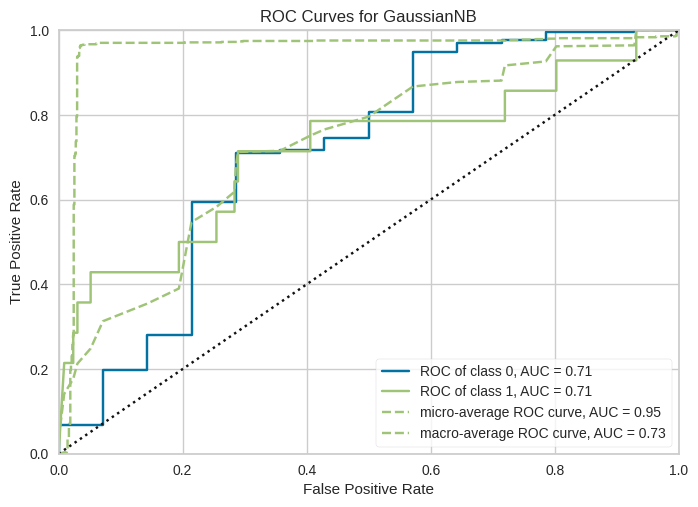

In [31]:
plot_model(tuned_nb)

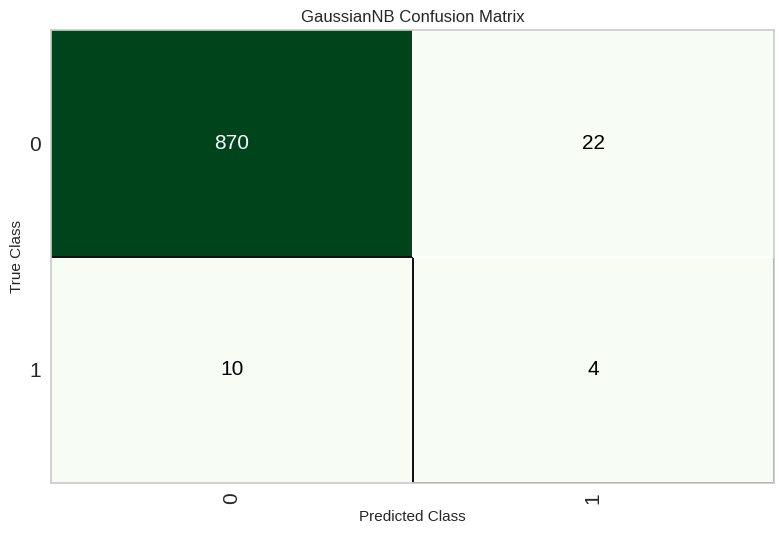

In [32]:
plot_model(tuned_nb, plot='confusion_matrix')

### 2. Using Pre-selected Important Features using XGBoost
For feature selection, see the notebook `customer_lead_generator_modelling.ipynb`.
#### 2.1. Initial Baseline Models

In [33]:
clf2 = setup(data=train_data,
            target = 'b_gekauft_gesamt',
            session_id=14,
            test_data=test_data,
            feature_selection=False,
            fix_imbalance=True,
            normalize='True',
            normalize_method='zscore',
            experiment_name='xbg_selected',
            n_jobs=-1)

,Description,Value
0,Session id,14
1,Target,b_gekauft_gesamt
2,Target type,Binary
3,Original data shape,"(3773, 18)"
4,Transformed data shape,"(6699, 18)"
5,Transformed train set shape,"(5944, 18)"
6,Transformed test set shape,"(755, 18)"
7,Numeric features,17
8,Rows with missing values,0.0%
9,Preprocess,True


In [34]:
best_model_xgb_selected = clf2.compare_models(fold=5, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9655,0.6514,0.1756,0.1156,0.1387,0.1224,0.1253,0.1880
knn,K Neighbors Classifier,0.9301,0.6737,0.3467,0.0806,0.1299,0.1080,0.1407,0.0480
lightgbm,Light Gradient Boosting Machine,0.9775,0.7031,0.0867,0.1278,0.1002,0.0900,0.0929,52.1800
gbc,Gradient Boosting Classifier,0.9771,0.6576,0.0867,0.1044,0.0944,0.0839,0.0840,0.6160
qda,Quadratic Discriminant Analysis,0.8854,0.5703,0.3689,0.0510,0.0895,0.0645,0.1025,0.0340
dt,Decision Tree Classifier,0.9639,0.5441,0.1111,0.0608,0.0769,0.0596,0.0636,0.0340
nb,Naive Bayes,0.8211,0.6817,0.4778,0.0417,0.0766,0.0500,0.0986,0.0280
xgboost,Extreme Gradient Boosting,0.9751,0.6860,0.0644,0.0708,0.0630,0.0512,0.0531,0.3320
lr,Logistic Regression,0.7826,0.7113,0.4778,0.0335,0.0625,0.0351,0.0787,0.0360
ridge,Ridge Classifier,0.7773,0.0000,0.4578,0.0312,0.0583,0.0307,0.0702,0.0320


#### 1.2. Auto-tuning the best model (Ada Boost Classifier)
Obtained initially from `compare_models` with highest 5-CV F1 score with pre-selected features using XGBoost.

In [35]:
ada = clf2.create_model('ada', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9702,0.6480,0.2222,0.1538,0.1818,0.1672,0.1701
1,0.9735,0.8415,0.4444,0.2667,0.3333,0.3207,0.3316
2,0.9685,0.5874,0.1000,0.0909,0.0952,0.0793,0.0794
3,0.9519,0.5721,0.0000,0.0000,0.0000,-0.0210,-0.0228
4,0.9635,0.6078,0.1111,0.0667,0.0833,0.0659,0.0682
Mean,0.9655,0.6514,0.1756,0.1156,0.1387,0.1224,0.1253
Std,0.0075,0.0984,0.1518,0.0902,0.1131,0.1157,0.1199


In [36]:
tuned_ada = clf2.tune_model(ada,
                      n_iter=5,
                      search_library='scikit-learn',
                      search_algorithm='random',
                      optimize='f1',
                      fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9719,0.6622,0.3333,0.2143,0.2609,0.2472,0.2535
1,0.9818,0.8090,0.2222,0.3333,0.2667,0.2578,0.2633
2,0.9752,0.6407,0.2000,0.2222,0.2105,0.1979,0.1982
3,0.9536,0.5458,0.0000,0.0000,0.0000,-0.0207,-0.0222
4,0.9801,0.6814,0.1111,0.2000,0.1429,0.1336,0.1396
Mean,0.9725,0.6678,0.1733,0.1940,0.1762,0.1632,0.1665
Std,0.0101,0.0846,0.1119,0.1080,0.0987,0.1019,0.1042


Fitting 5 folds for each of 5 candidates, totalling 25 fits


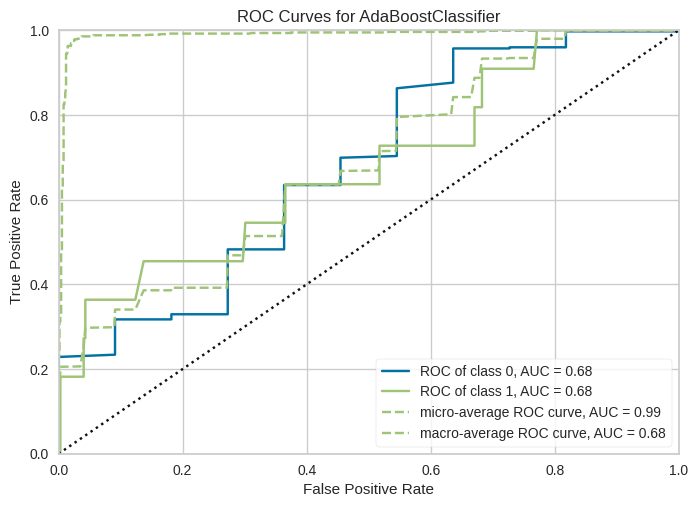

In [37]:
plot_model(tuned_ada)

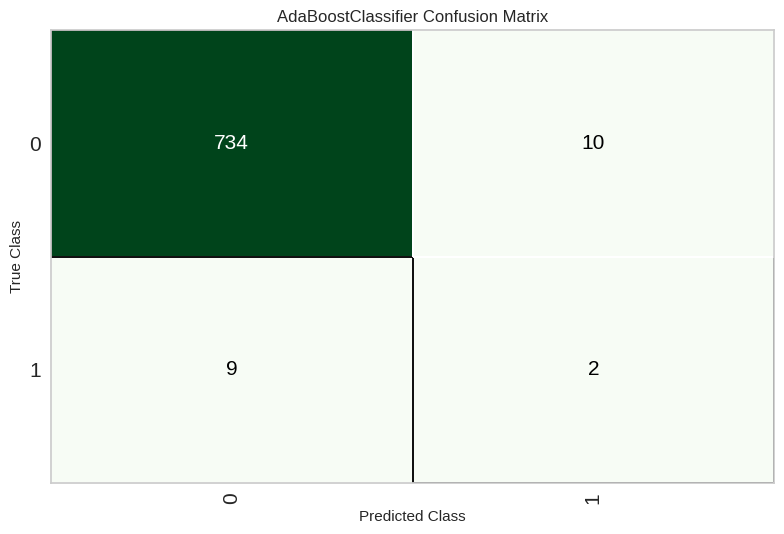

In [38]:
plot_model(tuned_ada, plot='confusion_matrix')